# Applied Data Science Capstone Project
# Finding the best Belgian restaurant location in NYC

Starting a new business is a big risk. However, there are a lot of things that we can do to mitigate that risk. One of these things is using data science to find out the prime location to set up shop. If you pick a location with high foot traffic, affordable rent and that's quite safe to boot, you can limit the risk involved.

In this notebook you'll find an overview of both my thought process during the analysis and all the code used in the process. I've tried annotating the code as thoroughly as possible. My apologies if something is still not quite clear. 

Let's start off by importing the important libraries for my analysis. This isn't a complete list, as some specific libraries will be added in the process. However, these are all libraries I know I'll need and will come in handy. The first hidden cell contains my project's ID and access token, which let's my notebook access data sources and other connections through IBM Watson. 

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import requests 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium
print("Done importing")

Done importing


## 1. Determining the best possible borough

NYC is an incredibly large city with tons of neighbourhoods. If I were to analyse each and every neighbourhood, I would surely bump into the free Fouraquare API limitations. Let's have a look at some data on borough-level first to identify the best borough before we dive into the neighbourhoods.

On a borough-level we'll look at:
- Population
- GDP
- GDP in relation to population
- Crime
- Crime in relation to population
- Types of crimes

### 1.1 Getting demographic data from wikipedia

In [3]:
# Step 1: Retrieve html file from page
data_url = urllib.request.urlopen("https://en.wikipedia.org/wiki/Demographics_of_New_York_City")
html_file = data_url.read()

# Step 2: Pass html file into BeautifulSoup
soup = BeautifulSoup(html_file, "html.parser")

# Step 3: Remove the 'th' tag that contains all the styling to ensure smooth processing in a dataframe
soup.th.decompose()

# Step 4: Extract the needed table
htmltable = soup.find("table", {"class":"wikitable sortable"})

# Step 5: Create a dataframe of the table.
raw_df = pd.read_html(str(htmltable))[0]
raw_df

Jurisdiction  \
                                             Borough   
0                                          The Bronx   
1                                           Brooklyn   
2                                          Manhattan   
3                                             Queens   
4                                      Staten Island   
5                                   City of New York   
6                                  State of New York   
7  Sources:[12][13][14] and see individual boroug...   

                                                      \
                                              County   
0                                              Bronx   
1                                              Kings   
2                                           New York   
3                                             Queens   
4                                           Richmond   
5                                   City of New York   
6                                  State of New York   
7  Sources:[12][13][14] and see individual boroug...   

                                          Population  \
                                     Estimate (2019)   
0                                            1418207   
1                                            2559903   
2                                            1628706   
3                                            2253858   
4                                             476143   
5                                            8336817   
6                                           19453561   
7  Sources:[12][13][14] and see individual boroug...   

                              Gross Domestic Product  \
                                  billions(2012 US$)   
0                                             42.695   
1                                             91.559   
2                                            600.244   
3                                             93.310   
4                                             14.514   
5                                            842.343   
6                                           1731.910   
7  Sources:[12][13][14] and see individual boroug...   

                                                      \
                                     per capita(US$)   
0                                              30100   
1                                              35800   
2                                             368500   
3                                              41400   
4                                              30500   
5                                             101000   
6                                              89000   
7  Sources:[12][13][14] and see individual boroug...   

                                           Land area  \
                                        square miles   
0                                              42.10   
1                                              70.82   
2                                              22.83   
3                                             108.53   
4                                              58.37   
5                                             302.64   
6                                           47126.40   
7  Sources:[12][13][14] and see individual boroug...   

                                                      \
                                            squarekm   
0                                             109.04   
1                                             183.42   
2                                              59.13   
3                                             281.09   
4                                             151.18   
5                                             783.83   
6                                          122056.82   
7  Sources:[12][13][14] and see individual boroug...   

                                             Density  \
                                        persons /mi2   
0

### 1.2 Cleaning the scraped table
As you can see in the dataframe above, there's a few rows we don't need, there's a double header and a few columns that aren't completely necessary. Before we move on and add our crime data, let's straighten this dataframe out a bit.

In [4]:
# Step 1: Keep the columns we need
cleaning_df = raw_df[[("Jurisdiction", "Borough"),("Population", "Estimate (2019)"),("Gross Domestic Product", "billions(2012 US$)")]]

# Step 2: Get rid of the 2-level header
cleaning_df.columns = cleaning_df.columns.droplevel(1)

# Step 3: Rename columns for clarity and drop summary & source rows
df_pop = cleaning_df.rename(columns={"Jurisdiction":"Borough", "Gross Domestic Product": "GDP"}).drop([5,6,7])
df_pop

,Borough,Population,GDP
0,The Bronx,1418207,42.695
1,Brooklyn,2559903,91.559
2,Manhattan,1628706,600.244
3,Queens,2253858,93.310
4,Staten Island,476143,14.514


### 1.3 Importing the crime data .csv 
That's already looking great. Time to move on to the other important dataset: crime-related data. You wouldn't want to set up shop in an unsafe place, would you? Luckily, the NYPD publishes borough-level crime statistics on their website. I downloaded the needed Excel-files, merged them in Microsoft Excel and then exported the .csv we'll use here.

The hidden cell below contains the code needed to load my .csv file. As this process makes use of my IBM API key, it's best that that cell isn't available to the public.

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
# Get crime data from csv
df_crime = pd.read_csv(body, sep=";", decimal=",")
df_crime

,Borough,Total Crimes,Murder,Rape,Robbery,Assault,Burglary,Grand_Larceny,Grand_Larceny_Auto,Unnamed: 9
0,Bronx,18889,81,388,3432,5632,1945,6210,1201,NaN
1,Brooklyn,26882,99,559,3908,5924,3507,11155,1730,NaN
2,Manhattan,26495,51,321,3013,3882,2468,16112,648,NaN
3,Queens,18582,69,417,2410,4083,2363,7751,1489,NaN
4,Staten Island,2367,14,54,218,612,270,1024,175,NaN


### 1.4 Cleaning the crime dataframe
Our loaded dataframe contains some valuable data, but it's not quite finished like this. We've got a column that serves no purpose and one of the Boroughs isn't named correctly. Let's fix that while we clean this dataframe up.

In [7]:
# Step 1: Filter out the unneeded columns
df_crime = df_crime.drop(labels="Unnamed: 9", axis=1)

# Step 3: Rename the inconsistent boroughs & out of place column name
df_crime = df_crime.replace({"Bronx": "The Bronx"})
df_crime = df_crime.rename(columns={"Total Crimes": "Total_Crimes"})
df_crime

,Borough,Total_Crimes,Murder,Rape,Robbery,Assault,Burglary,Grand_Larceny,Grand_Larceny_Auto
0,The Bronx,18889,81,388,3432,5632,1945,6210,1201
1,Brooklyn,26882,99,559,3908,5924,3507,11155,1730
2,Manhattan,26495,51,321,3013,3882,2468,16112,648
3,Queens,18582,69,417,2410,4083,2363,7751,1489
4,Staten Island,2367,14,54,218,612,270,1024,175


### 1.5 Merging the dataframes
At the moment we have most of the data we want ready. However, we have 2 different dataframes. Luckily, both dataframes contain the name of the borough, making merging these dataframes into 1 big dataframe that much easier.

In [8]:
# Merge both dataframes
boroughs = df_pop.merge(df_crime, left_on="Borough", right_on="Borough")
boroughs

,Borough,Population,GDP,Total_Crimes,Murder,Rape,Robbery,Assault,Burglary,Grand_Larceny,Grand_Larceny_Auto
0,The Bronx,1418207,42.695,18889,81,388,3432,5632,1945,6210,1201
1,Brooklyn,2559903,91.559,26882,99,559,3908,5924,3507,11155,1730
2,Manhattan,1628706,600.244,26495,51,321,3013,3882,2468,16112,648
3,Queens,2253858,93.310,18582,69,417,2410,4083,2363,7751,1489
4,Staten Island,476143,14.514,2367,14,54,218,612,270,1024,175


### 1.6 Further cleaning and adding extra, calculated columns
To be completely sure that everything is ready for action, let's have a look at the datatype for each column, as well as add some columns with some simple calculations.

In [9]:
# Check datatypes for the dataframe
boroughs.dtypes

Borough               object
Population            object
GDP                   object
Total_Crimes           int64
Murder                 int64
Rape                   int64
Robbery                int64
Assault                int64
Burglary               int64
Grand_Larceny          int64
Grand_Larceny_Auto     int64
dtype: object

In [10]:
# Step 1: Set correct datatypes! Populations & GDP don't contain objects, they contain integers and floats respectively.
boroughs["Population"] = boroughs["Population"].astype(int)
boroughs["GDP"] = boroughs["GDP"].astype(float)

# Step 2: Double check the datatypes to see if everything was changed properly.
boroughs.dtypes

Borough                object
Population              int64
GDP                   float64
Total_Crimes            int64
Murder                  int64
Rape                    int64
Robbery                 int64
Assault                 int64
Burglary                int64
Grand_Larceny           int64
Grand_Larceny_Auto      int64
dtype: object

In [11]:
# First things first, let's add columns where we normalise GDP & crime by population. A higher population generally means more crime. 
# Looking only at crime would give low-population boroughs an unfair advantage.
boroughs["Crime_by_pop"] = boroughs.Total_Crimes / boroughs.Population
boroughs["Gdp_by_pop"] = (boroughs.GDP / boroughs.Population) * 1000000

# When you look at crimes, there are various severities. Let's also look at how many of those crimes were felonies or misdemeanors.
boroughs["Total_felonies"] = boroughs.Murder + boroughs.Rape
boroughs["Total_misdemeanors"] = boroughs.Robbery + boroughs.Assault + boroughs.Burglary + boroughs.Grand_Larceny + boroughs.Grand_Larceny_Auto
boroughs["Felonies_by_pop"] = boroughs.Total_felonies / boroughs.Population
boroughs["Misdemeanors_by_pop"] = boroughs.Total_misdemeanors / boroughs.Population
boroughs["Felony_rate"] = boroughs.Total_felonies / boroughs.Total_Crimes
boroughs["Misdemeanor_rate"] = boroughs.Total_misdemeanors / boroughs.Total_Crimes

# Let's use our 'Borough' column as the index to make visualisation easier.
boroughs = boroughs.set_index("Borough")

boroughs

,Population,GDP,Total_Crimes,Murder,Rape,Robbery,Assault,Burglary,Grand_Larceny,Grand_Larceny_Auto,Crime_by_pop,Gdp_by_pop,Total_felonies,Total_misdemeanors,Felonies_by_pop,Misdemeanors_by_pop,Felony_rate,Misdemeanor_rate
Borough,,,,,,,,,,,,,,,,,,
The Bronx,1418207,42.695,18889,81,388,3432,5632,1945,6210,1201,0.013319,30.104914,469,18420,0.000331,0.012988,0.024829,0.975171
Brooklyn,2559903,91.559,26882,99,559,3908,5924,3507,11155,1730,0.010501,35.766590,658,26224,0.000257,0.010244,0.024477,0.975523
Manhattan,1628706,600.244,26495,51,321,3013,3882,2468,16112,648,0.016268,368.540424,372,26123,0.000228,0.016039,0.014040,0.985960
Queens,2253858,93.310,18582,69,417,2410,4083,2363,7751,1489,0.008245,41.400124,486,18096,0.000216,0.008029,0.026154,0.973846
Staten Island,476143,14.514,2367,14,54,218,612,270,1024,175,0.004971,30.482439,68,2299,0.000143,0.004828,0.028728,0.971272


### 1.7 Apply min-max feature scaling
When you want to compare multiple metrics across multiple boroughs applying min-max feature scaling makes things much easier. It reduces all data to numbers between 1 and 0. 1 being the highest value for a column, 0 being the lowest. All other values are proportionally scaled between these 2 reference points. 

Without this, it would hard to visualise say... population in the same graph as total crimes, as the axis required for population wouldn't display total crimes clearly.

However, it is worth noting that using this scaled data for comparing different metrics within the same neighbourhood is not a good idea and will give a distorted view on reality!

In [12]:
boroughs_norm=(boroughs-boroughs.min())/(boroughs.max()-boroughs.min())
boroughs_norm

,Population,GDP,Total_Crimes,Murder,Rape,Robbery,Assault,Burglary,Grand_Larceny,Grand_Larceny_Auto,Crime_by_pop,Gdp_by_pop,Total_felonies,Total_misdemeanors,Felonies_by_pop,Misdemeanors_by_pop,Felony_rate,Misdemeanor_rate
Borough,,,,,,,,,,,,,,,,,,
The Bronx,0.452098,0.048113,0.673955,0.788235,0.661386,0.871003,0.945030,0.517454,0.343717,0.659807,0.738978,0.000000,0.679661,0.673814,1.000000,0.727861,0.734539,0.265461
Brooklyn,1.000000,0.131537,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.671461,1.000000,0.489539,0.016729,1.000000,1.000000,0.607961,0.483087,0.710579,0.289421
Manhattan,0.553117,1.000000,0.984214,0.435294,0.528713,0.757453,0.615587,0.679024,1.000000,0.304180,1.000000,1.000000,0.515254,0.995778,0.455534,1.000000,0.000000,1.000000
Queens,0.853128,0.134526,0.661432,0.647059,0.718812,0.594038,0.653426,0.646586,0.445851,0.845016,0.289770,0.033375,0.708475,0.660272,0.387556,0.285487,0.824754,0.175246
Staten Island,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001116,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


## 2. Finding the best possible borough
### 2.1 A quick look at population, GDP and crimes (by population) by borough

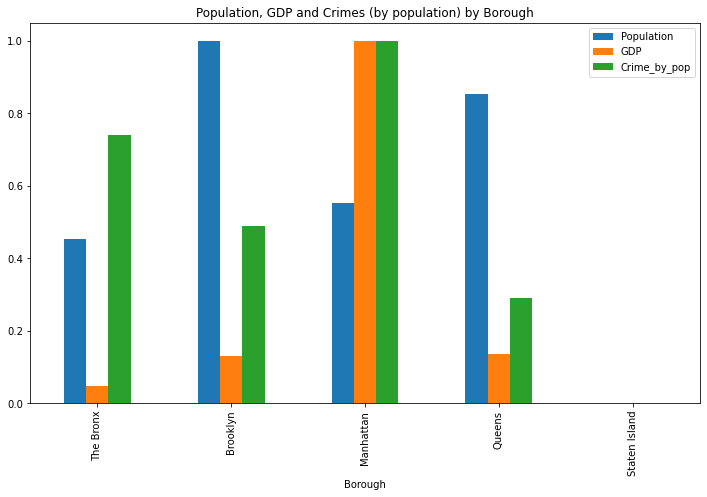

In [13]:
# Step 1: Filter out the columns we need
pop_by_borough = boroughs_norm[["Population", "GDP", "Crime_by_pop"]]

# Step 2: Visualise the filtered dataframe
ax1 = pop_by_borough.plot.bar(title="Population, GDP and Crimes (by population) by Borough", figsize=(12,7))
ax1

Judging by these results, Staten Island can already be ruled out. While it does have the lowest number of crimes, it also has the lowest population and GDP, which makes it unsuitable. 

The Bronx doesn't have much going for it at the moment either. The population & GDP are on the low end, while it's number of crimes is quite high when we compare it to the population. Add in an unruly reputation that doesn't attract many tourists, and we can safely exclude this borough as well.

This leaves us with 3 options: Queens, Brooklyn and Manhattan. 
Queens might have the lowest population, but it seems the safest borough by a long shot.
Brooklyn might be less safe than Queens, but it has a lot more potential clients.
Manhattan might not have as many people and might not be as safe, but this difference in GDP is enormous. Sometimes you just have to go where the money goes.

### 2.2 A more in-depth look at crime in the boroughs
First things first, let's have a look at how many felonies (murder & rape) were committed versus how many misdemeanors (larceny, assault, burglary...) were committed in each borough. 

*Note*: I did not use the normalised data for these graphs. While it would make it easier to compare between boroughs, it would also throw off the balance between felonies & misdemeanors inside a borough.

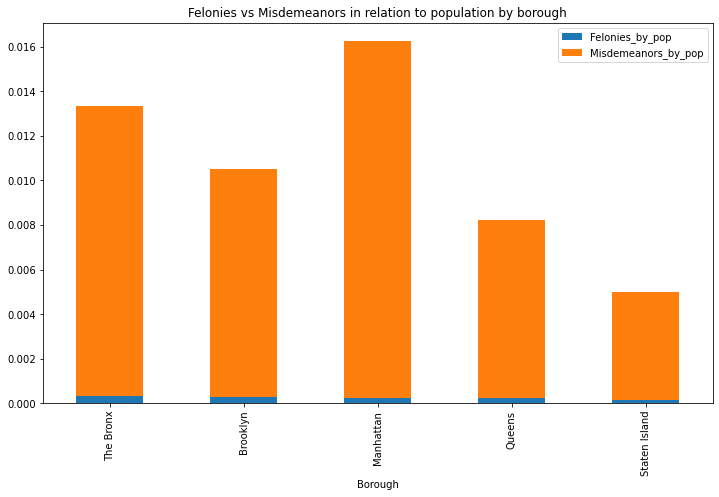

In [14]:
# Step 1: Filter out the columns we need
total_crimes_df = boroughs[["Felonies_by_pop", "Misdemeanors_by_pop"]]

# Step 2: Visualise the filtered dataframe
ax2 = total_crimes_df.plot.bar(stacked=True, title="Felonies vs Misdemeanors in relation to population by borough", figsize=(12,7))
ax2

Where the ratio of felonies to misdemeanors is fairly consistent across most boroughs, Manhattan is the odd one out. There are far more misdemeanors than felonies when we compare the two. My current hypothesis is that this is due to there being more theft in the area due to tourism and the high GDP of the area. Let's dive a bit deeper into the specific crime types to see if this is true!

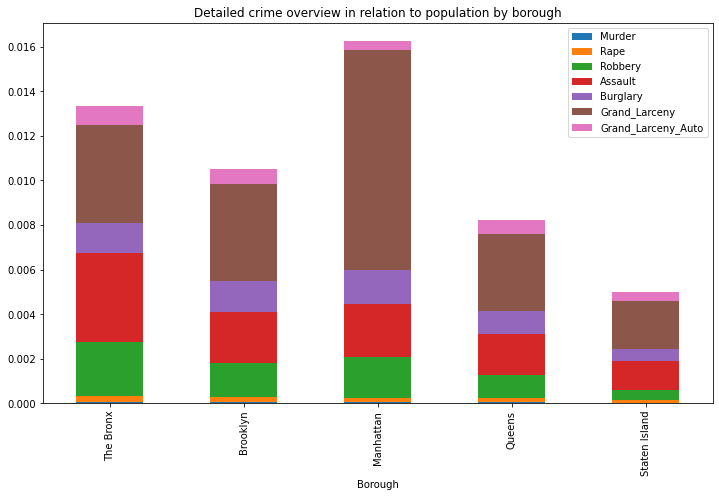

In [16]:
# Step 1: Filter out the columns we need
specific_crimes_df = boroughs[["Murder","Rape","Robbery","Assault","Burglary","Grand_Larceny","Grand_Larceny_Auto"]]
specific_crimes_df = specific_crimes_df[["Murder","Rape","Robbery","Assault","Burglary","Grand_Larceny","Grand_Larceny_Auto"]].div(boroughs.Population, axis=0)

# Step 2: Visualise the filtered dataframe
ax3 = specific_crimes_df.plot.bar(stacked=True, title="Detailed crime overview in relation to population by borough", figsize=(12,7))
ax3

Manhattan does seem to have a problem when it comes to grand larceny. 

There are a few types of crime that have larger impacts on businesses in the area. The felonies, murder and rape, and assault being more common is bad for business. The more these crimes happen in the area, the more residents will be afraid to go out at night. And when they don't go out at night, they probably won't dine at your restaurant which is bad for business.

On the other hand, burglary & grand larceny stand out as important crimes as well. You don't want your restaurant to be the victim of burglarly or the valuables that are part of your interior stolen.

Let's have a better look at these specific crimes below.

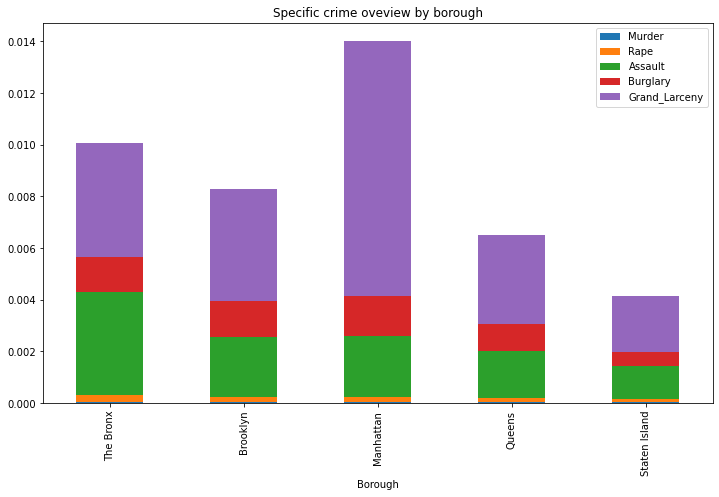

In [17]:
# Step 1: Filter out the columns we need
specific_crimes_df2 = specific_crimes_df[["Murder","Rape", "Assault", "Burglary","Grand_Larceny"]]

# Step 2: Visualise the filtered dataframe
ax4 = specific_crimes_df2.plot.bar(stacked=True, title="Specific crime oveview by borough", figsize=(12,7))
ax4

### 2.4 The best possible borough is...
Queens. 

But why Queens? As mentioned in section 2.1, the preliminary candidates were Brooklyn, Manhattan and Queens.

Manhattan seemed to be a great pick with its bustling economy. However, the chances of being the victim of grand larceny in this borough make this a risky investment. We also need to take into account that the presence of Wall Street likely skews GDP heavily into Manhattan's favour. 

Brooklyn looked great at first sight and is definitely a great second choice. A lot of people, an ok GDP and relatively low crime. There's nothing inherently wrong with Brooklyn, it's just that Queens is a much safer choice.

Queens is our best bet. The chances of possible customers being spooked by the occurence of felonies is minimal and so is the chance of being the victim of burglary or grand larceny. On top of that, the GDP in the area is rather high. 

Fun fact: Queens is promoted by quite a few travel blogs and [NYC itself](https://www.nycgo.com/boroughs-neighborhoods/queens) as a place that houses many cuisines and a hotspot for foodies, a perfect fit for a restaurant!
## 3. Finding the best neighbourhood in Queens
Now that we have our best borough, it's time to start looking at each neighbourhood in Queens. Ideally, we want a neighbourhood with a lot of restaurants of different cuisines, but nothing too similar to Belgian cuisine like French or German. These areas will be hotspots for foodies who are looking to try something new. Locals and passing tourists will also stop by these places to have a nice meal. 

### 3.1 Getting the basic neighbourhood data
As the first step to create my dataframe, I'll be importing a .csv file that contains the average housing cost across the past 2 years. Of course, commercial real estate is always more expensive than regular real estate. However, this data is nearly impossible to find. This data should still give us a rough indicator of how expensive it would be to buy the property for our restaurant in said neighbourhood. On top of that, it'll supply me with the basic list of neighbourhoods I'll need for my analysis.

As usual, the hidden cell contains sensitive information. In this case, this information is used to load the .csv containing the base data found on streeteasy.com. 

In [30]:
# The code was removed by Watson Studio for sharing.

In [31]:
# Get housing data from csv
Neighbourhoods_1 = pd.read_csv(body, sep=";")
Neighbourhoods_1.head()

,Neighbourhood,Average_housing_cost
0,Astoria,934910
1,Auburndale,932072
2,Bayside,647590
3,Bellerose,704789
4,Briarwood,351848


### 3.2 Adding in the geographic data
Currently our dataframe is a bit barren and we need our latitude and longitude in order to run queries through the Foursquare API. Luckily the geopy library will save us the trouble of manually looking up the coordinates of each neighbourhood. Let's start by importing it and creating a loop to fetch the coordinates of each neighbourhood in my current dataframe.

Fun fact: always define extra information when using geopy and don't just look for a neighbourhood's name. Northwestern Queens turned into Oslo and Jamaica Hills turned into Manilla during previous attempts where I didn't specify more information!

In [37]:
from geopy import geocoders 
from geopy.geocoders import Nominatim

In [123]:
# Define empty arrays to serve as columns in a new dataframe
loc_lat = []
loc_lng = []
loc_neigh = []

# Create a loop that will loop through the neighbourhoods in the oroginal dataframe and store the name, 
# latitude and longitude of each neighbourhood in the corresponding array defined above.
# By printing an error for each neighbourhood that wasn't found, I will know exactly how many neighbourhoods were unable to be matched.
for neighbourhood in Neighbourhoods_1.Neighbourhood:
    try:
        inputNeigh = neighbourhood
        location = geolocator.geocode("{}, Queens, New York, USA".format(inputNeigh))
        loc_lat.append(location.latitude)
        loc_lng.append(location.longitude)
        loc_neigh.append(inputNeigh)
    except:
        print("Error, skipping neighbourhood...")

# Assemble the new dataframe
df_coordinates = pd.DataFrame({"Neighbourhood":loc_neigh,"Lat":loc_lat, "Lng":loc_lng})

Error, skipping neighbourhood...
Error, skipping neighbourhood...


In [124]:
# Merge the 2 dataframes together to create one that contains both the housing costs & the coordinates.
Neighbourhoods = df_coordinates.merge(Neighbourhoods_1, left_on="Neighbourhood", right_on="Neighbourhood")
Neighbourhoods.head()

,Neighbourhood,Lat,Lng,Average_housing_cost
0,Astoria,40.772014,-73.930267,934910
1,Auburndale,40.761452,-73.789724,932072
2,Bayside,40.768435,-73.777077,647590
3,Bellerose,40.732778,-73.717778,704789
4,Briarwood,40.709256,-73.820139,351848


In [125]:
# We did get 2 errors... Let's see which neighbourhoods were dropped and if all of our coordinates look correct.
Neighbourhoods

,Neighbourhood,Lat,Lng,Average_housing_cost
0,Astoria,40.772014,-73.930267,934910
1,Auburndale,40.761452,-73.789724,932072
2,Bayside,40.768435,-73.777077,647590
3,Bellerose,40.732778,-73.717778,704789
4,Briarwood,40.709256,-73.820139,351848
5,Brookville,40.658691,-73.746164,789499
6,Cambria Heights,40.694547,-73.738465,581097
7,Central Queens,40.749824,-73.797634,546753
8,Clearview,40.782778,-73.788611,621955
9,College Point,40.787601,-73.845968,881034


We seem to have lost a few neighbourhoods since Geopy couldn't locate their coordinates. As we still have 53 neighbourhoods left, we can continue our analysis without Jamaica Hills & Central Queens. Jamaica Hills is rather small & focused on housing, while Central Queens is a catch-all name for neighbourhoods like Forest Hills. We are not missing valuable data by excluding these 2 neighbourhoods.
### 3.3 Adding in the venue data 
It's time to see which kinds of businesses are located in each neighbourhood. I'll define some sensitive information like my Foursquare ID and secret below in a hidden cell. Once that's done, let's start making those API calls!

In [55]:
# The code was removed by Watson Studio for sharing.

In [126]:
# Define a function to retrieve nearby venues for each neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Add all the necessary parameters to the request URL to fetch the data
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the actual GET request with the url
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # Only keep venue name, venue latitude, venue longitude and venue category from the returned data.
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v["venue"]["name"], 
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["categories"][0]["name"]) for v in results])

        # Create a new dataframe with the fetched data
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["Neighbourhood", 
                  "Neighbourhood Latitude", 
                  "Neighbourhood Longitude", 
                  "Venue", 
                  "Venue Latitude", 
                  "Venue Longitude", 
                  "Venue Category"]
    
    return(nearby_venues)

In [127]:
# Get the names of the neighbourhoods in Queens to enter into our function
Queens_neighbourhood_names = Neighbourhoods.Neighbourhood

# Get the latitudes of the neighbourhoods in Queens to enter into our function
Queens_neighbourhood_lats = Neighbourhoods.Lat

# Get the longitudes of the neighbourhoods in Queens to enter into our function
Queens_neighbourhood_lngs = Neighbourhoods.Lng

In [128]:
# Call the function on our neighbourhoods to get local venue data.
Queens_venues = getNearbyVenues(names = Queens_neighbourhood_names, latitudes  = Queens_neighbourhood_lats
, longitudes = Queens_neighbourhood_lngs, radius = 1250)

Astoria
Auburndale
Bayside
Bellerose
Briarwood
Brookville
Cambria Heights
Central Queens
Clearview
College Point
Corona
Douglaston
East Elmhurst
Elmhurst
Flushing
Forest Hills
Fresh Meadows
Glen Oaks
Glendale
Hillcrest
Hollis
Howard Beach
Jackson Heights
Jamaica
Jamaica Estates
Kew Gardens
Laurelton
Little Neck
Long Island City
Maspeth
Middle Village
North Corona
Northeast Queens
Northwest Queens
Oakland Gardens
Ozone Park
Pomonok
Queens Village
Rego Park
Richmond Hill
Ridgewood
Rockaway All
Rosedale
South Jamaica
South Ozone Park
South Queens
South Richmond Hill
Springfield Gardens
St. Albans
Sunnyside
The Rockaways
Utopia
Whitestone
Woodhaven
Woodside


In [129]:
# Let's have a quick look at our new dataframe!
print("We've retrieved a grand total of {} venues! These venues belong to {} unique categories.".format(Queens_venues.shape[0],len(Queens_venues["Venue Category"].unique())))

Queens_venues.head()

We've retrieved a grand total of 4236 venues! These venues belong to 322 unique categories.


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.772014,-73.930267,Welling Court Murals,40.771526,-73.931513,Street Art
1,Astoria,40.772014,-73.930267,Vesta Trattoria & Wine Bar,40.769809,-73.927796,Italian Restaurant
2,Astoria,40.772014,-73.930267,SVL Bar,40.772078,-73.927207,Greek Restaurant
3,Astoria,40.772014,-73.930267,Exo Astoria,40.772467,-73.925803,Residential Building (Apartment / Condo)
4,Astoria,40.772014,-73.930267,Infinitea NY,40.771669,-73.924006,Bubble Tea Shop


Now that we have our list of venues, let's have a look at how these venues are distributed across the neighbourhoods and Venue Categories. This will give us an insight into which neighbourhoods have a higher density of business, which don't and the types of businesses in each neighbourhood. 

If we notice that a lot of neighbourhoods have few businesses, this might mean that we may need to define a larger radius in our function, our coordinates are incorrect or, if neither's the case, that the neighbourhood just isn't a good fit for a restaurant.

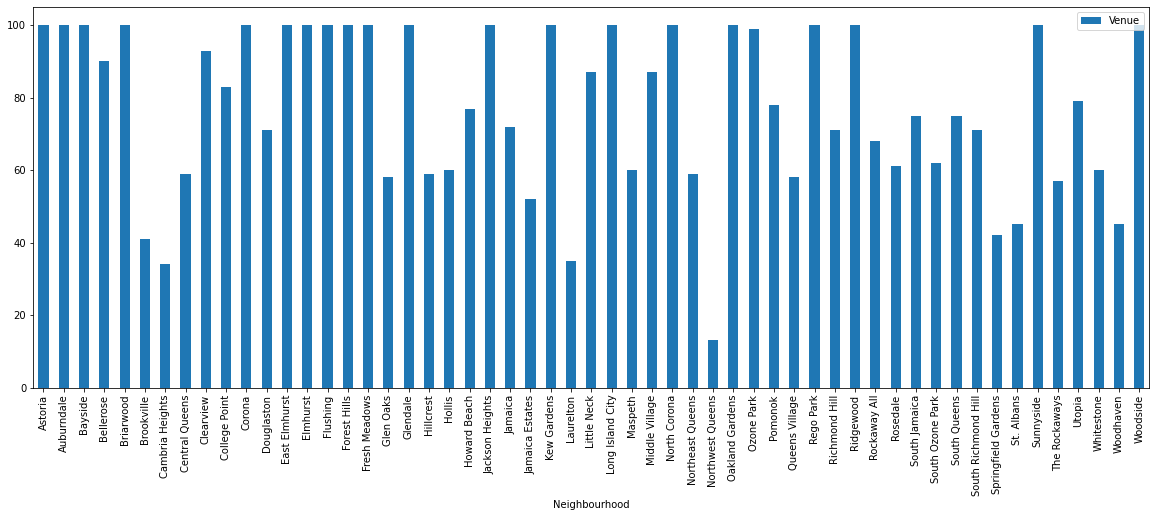

In [130]:
# Step 1: Filter out the columns we need
Venues_quantity = Queens_venues.groupby(["Neighbourhood"])["Venue"].count()

# Step 2: Visualise the filtered dataframe
Quantity = pd.DataFrame(data=Venues_quantity, index = None)
Quantity.plot.bar(figsize=(20,7))

As we can see in the graph above, most neighbourhoods have a solid amount of venues that were retrieved. Nothwest Queens lags behind, but there might be a good reason for that. 

Let's have a look at the most popular venue categories!

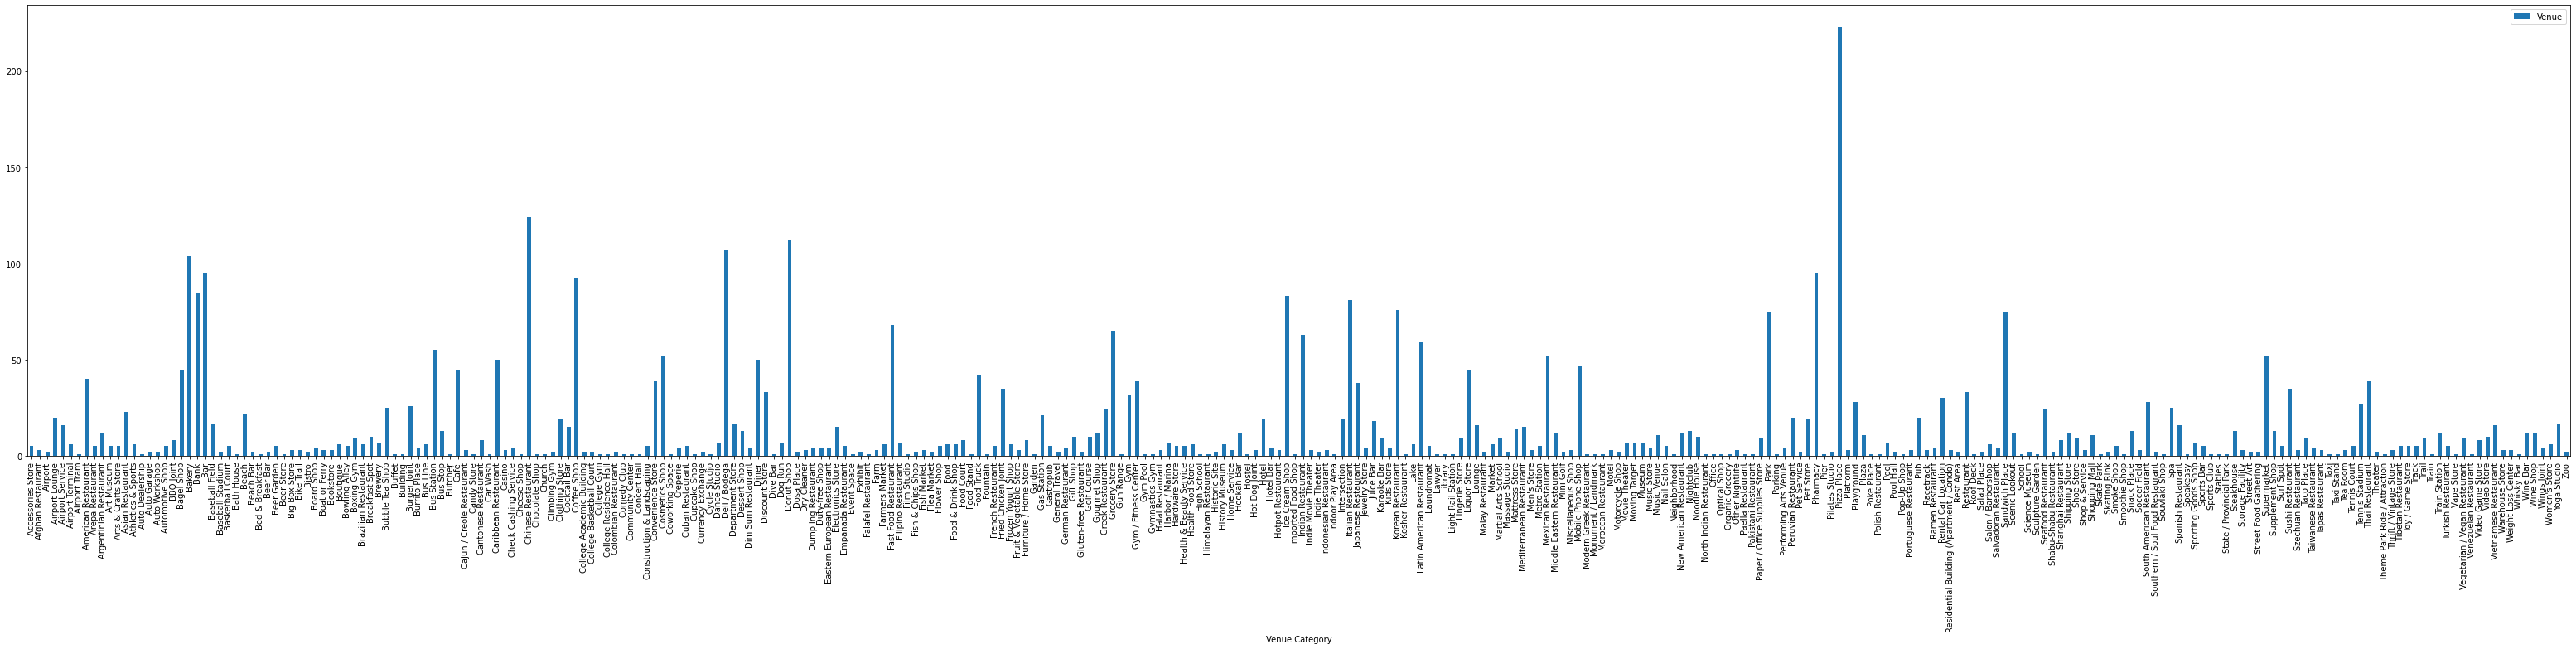

In [131]:
# Step 1: Filter out the columns we need
Category_quantity = Queens_venues.groupby(["Venue Category"])["Venue"].count()

# Step 2: Visualise the filtered dataframe
Category_Quantity_df = pd.DataFrame(data=Category_quantity, index = None)
Category_Quantity_df.plot.bar(figsize=(55,10))

Due to the sheer amount of categories, this graph isn't too useful, as it's rather unclear what's what. However, it is interesting to note that the big spike are pizza places. It seems like the people from Queens do love their pizza.

Anyways, enough trivia. Let's merge the dataframe containing the total amount of venues with our original dataframe to get the 'Total Venues' metric!

In [133]:
Queens_df = Neighbourhoods.merge(Quantity, left_on="Neighbourhood", right_on="Neighbourhood")

In [134]:
# Before we can use it, we'll have to rename the column that's simply named "venue" to avoid problems further down the line.
Queens_df = Queens_df.rename(columns={"Venue": "Total_venues"})
Queens_df.head()

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues
0,Astoria,40.772014,-73.930267,934910,100
1,Auburndale,40.761452,-73.789724,932072,100
2,Bayside,40.768435,-73.777077,647590,100
3,Bellerose,40.732778,-73.717778,704789,90
4,Briarwood,40.709256,-73.820139,351848,100


Now that we have the total amount of businesses retrieved by our API... let's have a look at how many of these were restaurants, burger joints, food trucks. The ratio of restaurants vs total venues retrieved is an interesting metric to consider!

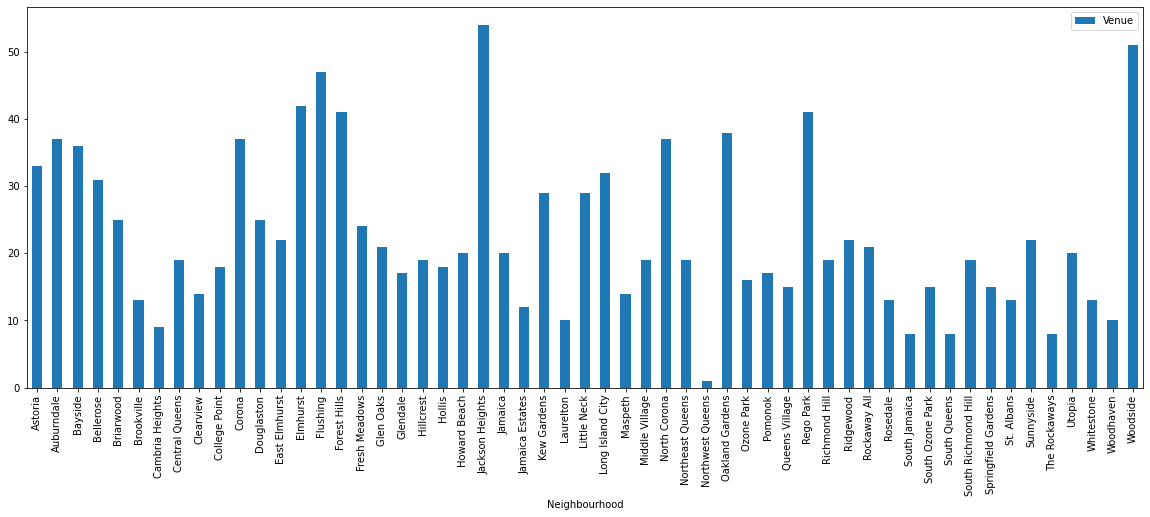

In [142]:
# Step 1: Filter out the columns we need and run a few calculations
Queens_Restaurants = Queens_venues.loc[lambda x: x["Venue Category"].str.contains(".*(Restaurant|Joint|Food).*", regex = True)]
Restaurant_quantity = Queens_Restaurants.groupby(["Neighbourhood"])["Venue"].count()
Res_Quantity = pd.DataFrame(data=Restaurant_quantity, index = None)

# Step 2: Visualise the filtered dataframe
Res_Quantity.plot.bar(figsize=(20,7))

Jackson Heights and Woodside seem to be very interesting neighbourhoods due to the high number of restaurants. Northwest Queens is looking less and less ideal by the minute.

Let's also have a quick look at how many unique types of restaurants are present in each neighbourhood. This data could be very interesting at a later point as well, so let's add it all to our dataframe as well.

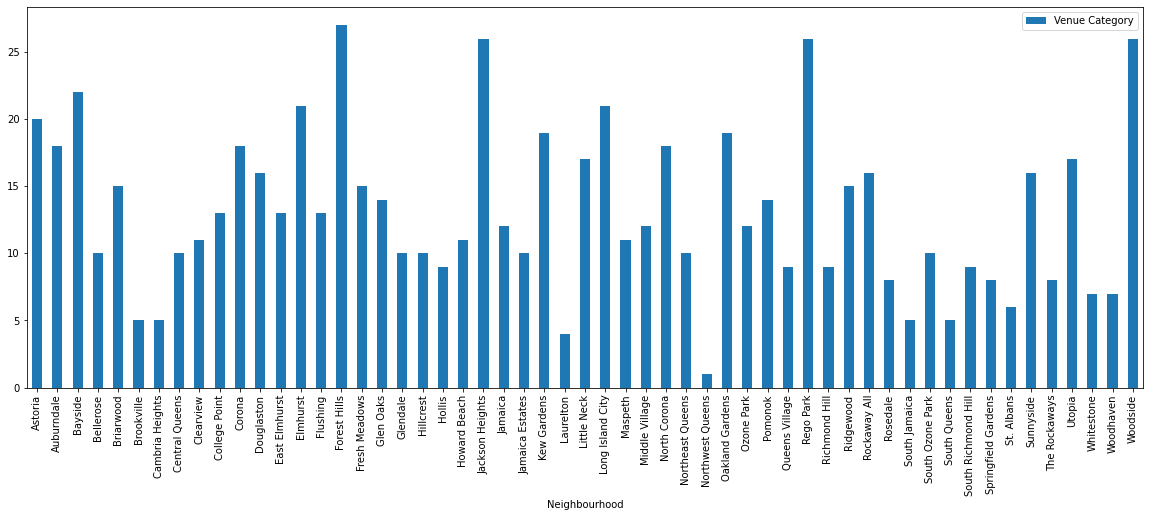

In [152]:
# Step 1: Calculate the amount of different categories within a single neighbourhood
Res_type_quantity = Queens_Restaurants.groupby(["Neighbourhood"])["Venue Category"].nunique()
Res_type_quantity_df = pd.DataFrame(data=Res_type_quantity, index = None)

# Step 2: Visualise the filtered dataframe
Res_type_quantity_df.plot.bar(figsize=(20,7))

In [143]:
# Add the total amount of restaurants to the dataframe as well
Queens_df_v2 = Queens_df.merge(Res_Quantity, left_on="Neighbourhood", right_on="Neighbourhood")

In [145]:
# Rename the column so that it makes sense
Queens_df = Queens_df_v2.rename(columns={"Venue": "Total_restaurants"})

In [148]:
# Calculate the ratio of restaurants. A high or low ratio of restaurants might both be interesting 
# statistics to take into account for our final decision. 
Queens_df["Restaurant_ratio"] = Queens_df.Total_restaurants / Queens_df.Total_venues
Queens_df.head()

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio
0,Astoria,40.772014,-73.930267,934910,100,33,0.330000
1,Auburndale,40.761452,-73.789724,932072,100,37,0.370000
2,Bayside,40.768435,-73.777077,647590,100,36,0.360000
3,Bellerose,40.732778,-73.717778,704789,90,31,0.344444
4,Briarwood,40.709256,-73.820139,351848,100,25,0.250000


In [154]:
# Add another column with the unique types & rename it
Queens_df_v2 = Queens_df.merge(Res_type_quantity_df, left_on="Neighbourhood", right_on="Neighbourhood")
Queens_df = Queens_df_v2.rename(columns={"Venue Category": "Unique_restaurant_types"})
Queens_df.head()

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types
0,Astoria,40.772014,-73.930267,934910,100,33,0.330000,20
1,Auburndale,40.761452,-73.789724,932072,100,37,0.370000,18
2,Bayside,40.768435,-73.777077,647590,100,36,0.360000,22
3,Bellerose,40.732778,-73.717778,704789,90,31,0.344444,10
4,Briarwood,40.709256,-73.820139,351848,100,25,0.250000,15


### 3.4 Using One hot encoding to find the top categories for each neighbourhood
Our current dataset of venues cannot be processed by machine learning algorithms as is. We need to apply a method named one hot encoding first. This method will turn categorical variables (strings) into numerical values. 

A simple example would be a column that contains a simple customer / non-customer value. After one hot encoding you would have 2 columns, one named 'customer' and another named 'non-customer'. If the original value was customer, that column will contain a 1.

This principle is applied at a much larger scale here with our 322 retrieved venue categories!

In [156]:
# Step 1: Create a dataframe that will be used to generate the new column names
Queens_onehot = pd.get_dummies(Queens_venues[["Venue Category"]], prefix="", prefix_sep="")

# Step 2: Add the neighbourhood column back to dataframe for clarity
Queens_onehot["Neighbourhood"] = Queens_venues["Neighbourhood"] 

# Step 3: Move neighbourhood column to the first column, which makes everything easier to understand.
fixed_columns = [Queens_onehot.columns[-1]] + list(Queens_onehot.columns[:-1])
Queens_onehot = Queens_onehot[fixed_columns]

# Step 4: Group the results by neighbourhood to identify neighbour-hood level trends.
Queens_venues_grouped = Queens_onehot.groupby('Neighbourhood').mean().reset_index()
Queens_venues_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,Arepa Restaurant,...,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Astoria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,...,0.00,0.01,0.00,0.0,0.00,0.030000,0.0,0.0,0.00,0.0
1,Auburndale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,...,0.01,0.00,0.00,0.0,0.00,0.000000,0.0,0.0,0.00,0.0
2,Bayside,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,...,0.01,0.00,0.01,0.0,0.01,0.000000,0.0,0.0,0.01,0.0
3,Bellerose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,...,0.00,0.00,0.00,0.0,0.00,0.011111,0.0,0.0,0.00,0.0
4,Briarwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,...,0.00,0.00,0.00,0.0,0.00,0.000000,0.0,0.0,0.01,0.0


While this gigantic dataframe with 323 columns is great for algorithms, it isn't going to help us humans. Let's just trim the fat and turn this into the 10 most common venue categories for each neighbourhood. 

In [157]:
# Step 1: Let's define a function where we sort the row from high-low and then take the first x columns in that row.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Step 2: Let's set a cap of 10 for now. If we want to change it later, we can simply do so by adjusting this variable
num_top_venues = 10

indicators = ["st", "nd", "rd"]

# Step 3: Let's create an array that'll give our new dataframe it's column names.
columns = ["Neighbourhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append("{}{} Most Common Venue".format(ind+1, indicators[ind]))
    except:
        columns.append("{}th Most Common Venue".format(ind+1))

# Step 4: Create a brand-new dataframe with our function!
Queens_venues_sorted = pd.DataFrame(columns=columns)
Queens_venues_sorted["Neighbourhood"] = Queens_venues_grouped["Neighbourhood"]

for ind in np.arange(Queens_venues_grouped.shape[0]):
    Queens_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Queens_venues_grouped.iloc[ind, :], num_top_venues)

Queens_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Greek Restaurant,Grocery Store,Café,Pizza Place,Park,Bar,Mexican Restaurant,Wine Shop,Gym,Bubble Tea Shop
1,Auburndale,Korean Restaurant,Pizza Place,Ice Cream Shop,Café,Greek Restaurant,Mobile Phone Shop,Coffee Shop,Pharmacy,Diner,Thai Restaurant
2,Bayside,Pizza Place,Bar,Cosmetics Shop,Pharmacy,Burger Joint,Bakery,Gym / Fitness Center,Sushi Restaurant,Korean Restaurant,Greek Restaurant
3,Bellerose,Indian Restaurant,Mobile Phone Shop,Deli / Bodega,Grocery Store,Pizza Place,Italian Restaurant,Intersection,Pharmacy,Food Truck,Convenience Store
4,Briarwood,Pizza Place,Donut Shop,Sandwich Place,Coffee Shop,Bank,Chinese Restaurant,Pharmacy,Ice Cream Shop,Cosmetics Shop,Indian Restaurant


## 4. Using machine learning to identify similar neighbourhoods
There quite a lot of neighbourhoods in Queens. Too many to manually go over each and every one of them and compare them. That's where machine learning comes in. By creating clusters of similar neighbourhoods, finding the most suitable cluster and then analysing the neighbourhoods within said clusters is a far more efficient approach.

### 4.1 Clustering using kmeans
Kmeans is the most suited machine learning algorithm for this use case. Kmeans is a method of unsupervised learning. This means that the algorithm will identify patterns on its own, without the need for a pre-existing categorisation. 

To sum it up, kmeans will divide your dataset into 'k' clusters. It does so by creating k 'centroids'. Then they calculate the distance from each data point to each centroid. The closest centroid will then become its cluster. Once the cluster is formed, the centroid is placed in the middle of it's cluster and this process repeats itself until the centroids stop moving. 

Now, let's get started by creating a dataframe suitable for kmeans clustering by dropping the neighbourhood-column.

In [158]:
Queens_grouped_kmeans = Queens_venues_grouped.drop("Neighbourhood", 1)

Before we can effectively use the kmeans algorithm, we first need to find out the optimal value of k. There are many methods to do so, but the easiest method is the Elbow method. Yellowbrick offers an incredibly easy and robust way of calculating this as well!

This method is based off of testing the algorithm with multiple k-values, calculating the sum of square errors (SSE) or 'distortion' and then seeing where the distortion graph suddenly 'flattens' out. This change can be rather subtle though. The idea behind it is that the SSE will continue to decrease heavily as important clusters are added. However, once you start adding more clusters than needed, it will decrease far slower.

The mathematical formula for SSE is:


This means you subtract the centroid value from the datapoint value, square it and then sum it all up.

In [159]:
# Step 1: Import the needed resources to use Yellowbrick's Elbow method
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

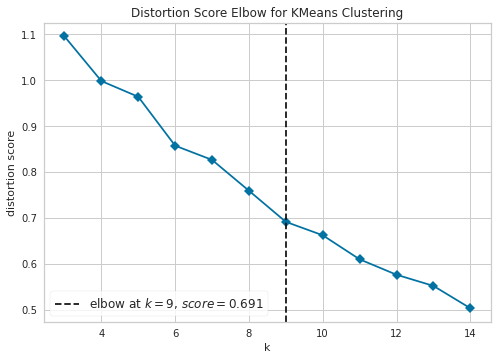

In [161]:
# Step 2: Set the correct model, kmeans in this case
model = KMeans()

# Step 3: Call the visualiser and define a range of k values that you want to test
visualizer = KElbowVisualizer(model, k=(3,15), timings=False)

# Step 4: Fit the data and show the graph
visualizer.fit(Queens_grouped_kmeans)        
visualizer.show()

The elbow isn't quite as clear as it usually is in this graph. However, 9 clusters should still be plenty of clusters to produce an acceptable result with the size of our current data set. 

Let's set our k to 9 and see what our algorithm can do with our current data set.

In [162]:
# Step 1: Set k to 9
kclusters = 9

# Step 2: Run the clustering algorithm
Queens_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Queens_grouped_kmeans)

In [166]:
# Step 3: Every neighbourhood has been assigned a cluster number, now we merge the dataframe with the cluster numbers with our original dataframe.
# Queens_venues_sorted = Queens_venues_sorted.drop(labels="Cluster Labels", axis=1) # This line is only needed when I need to rerun the code.
Queens_venues_sorted.insert(0, "Cluster Labels", Queens_kmeans.labels_)

# Step 4: Merge Queens_merged with Queens_venues_sorted to add latitude/longitude for each neighbourhood
Queens_df_total = Queens_df.join(Queens_venues_sorted.set_index("Neighbourhood"), on="Neighbourhood")

Queens_df_total.head()

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,40.772014,-73.930267,934910,100,33,0.330000,20,3,Greek Restaurant,Grocery Store,Café,Pizza Place,Park,Bar,Mexican Restaurant,Wine Shop,Gym,Bubble Tea Shop
1,Auburndale,40.761452,-73.789724,932072,100,37,0.370000,18,0,Korean Restaurant,Pizza Place,Ice Cream Shop,Café,Greek Restaurant,Mobile Phone Shop,Coffee Shop,Pharmacy,Diner,Thai Restaurant
2,Bayside,40.768435,-73.777077,647590,100,36,0.360000,22,3,Pizza Place,Bar,Cosmetics Shop,Pharmacy,Burger Joint,Bakery,Gym / Fitness Center,Sushi Restaurant,Korean Restaurant,Greek Restaurant
3,Bellerose,40.732778,-73.717778,704789,90,31,0.344444,10,1,Indian Restaurant,Mobile Phone Shop,Deli / Bodega,Grocery Store,Pizza Place,Italian Restaurant,Intersection,Pharmacy,Food Truck,Convenience Store
4,Briarwood,40.709256,-73.820139,351848,100,25,0.250000,15,1,Pizza Place,Donut Shop,Sandwich Place,Coffee Shop,Bank,Chinese Restaurant,Pharmacy,Ice Cream Shop,Cosmetics Shop,Indian Restaurant


### 4.2 Generate a map of the created clusters
It's time to see where each cluster is located. To visualise the clusters on a map, I'll be using the folium library. 

In [168]:
# Step 1: Define the latitude and longitude the map needs to be zoomed into.
latitude = 40.7282
longitude = -73.7949

# Step 2: Create a map and set its location and starting zoom.
Queens_cluster_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Step 3: Give each cluster its own colour.
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Step 4: Loop through the dataframe to add a marker to each neighbourhood.
markers_colors = []
for lat, lon, poi, cluster in zip(Queens_df_total["Lat"], Queens_df_total["Lng"], Queens_df_total["Neighbourhood"], Queens_df_total["Cluster Labels"]):
    label = folium.Popup(str(poi) + " Cluster " + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Queens_cluster_map)
       
Queens_cluster_map

### 4.3 Analysing each cluster to find the optimal cluster
Our first cluster contains a large amount of korean restaurants, chinese restaurants, bubble tea shops, hotpot restaurants, martial arts schools, karaoke... It's quite safe to say that this cluster is made up of predominantly asian neighbourhoods. While there is a large amount of restaurants, this cluster might not be the best fit.

In [171]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 0]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Auburndale,40.761452,-73.789724,932072,100,37,0.370000,18,0,Korean Restaurant,Pizza Place,Ice Cream Shop,Café,Greek Restaurant,Mobile Phone Shop,Coffee Shop,Pharmacy,Diner,Thai Restaurant
7,Central Queens,40.749824,-73.797634,546753,59,19,0.322034,10,0,Korean Restaurant,Pizza Place,Chinese Restaurant,Pharmacy,Bus Station,Park,Martial Arts School,Bus Stop,Sushi Restaurant,Bike Trail
14,Flushing,40.765430,-73.817429,815690,100,47,0.470000,13,0,Korean Restaurant,Bubble Tea Shop,Bakery,Karaoke Bar,Chinese Restaurant,Coffee Shop,Hotpot Restaurant,Pizza Place,Supermarket,Japanese Restaurant
19,Hillcrest,40.749824,-73.797634,989715,59,19,0.322034,10,0,Korean Restaurant,Pizza Place,Chinese Restaurant,Pharmacy,Bus Station,Park,Martial Arts School,Bus Stop,Sushi Restaurant,Bike Trail
32,Northeast Queens,40.749824,-73.797634,732875,59,19,0.322034,10,0,Korean Restaurant,Pizza Place,Chinese Restaurant,Pharmacy,Bus Station,Park,Martial Arts School,Bus Stop,Sushi Restaurant,Bike Trail
34,Oakland Gardens,40.753991,-73.765966,388993,100,38,0.380000,19,0,Korean Restaurant,Coffee Shop,Bakery,Sandwich Place,Bar,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Supplement Shop,Yoga Studio


The 2nd cluster doesn't seem to have a direct theme to it. There are a decent amout of restaurants, but also parks, banks, train stations... This could be a great back-up cluster!

In [172]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 1]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bellerose,40.732778,-73.717778,704789,90,31,0.344444,10,1,Indian Restaurant,Mobile Phone Shop,Deli / Bodega,Grocery Store,Pizza Place,Italian Restaurant,Intersection,Pharmacy,Food Truck,Convenience Store
4,Briarwood,40.709256,-73.820139,351848,100,25,0.250000,15,1,Pizza Place,Donut Shop,Sandwich Place,Coffee Shop,Bank,Chinese Restaurant,Pharmacy,Ice Cream Shop,Cosmetics Shop,Indian Restaurant
8,Clearview,40.782778,-73.788611,621955,93,14,0.150538,11,1,Pizza Place,Donut Shop,Bank,Cosmetics Shop,Park,Clothing Store,Bakery,Bagel Shop,Pharmacy,Shoe Store
9,College Point,40.787601,-73.845968,881034,83,18,0.216867,13,1,Deli / Bodega,Donut Shop,Pizza Place,Asian Restaurant,Park,Discount Store,Pharmacy,Gym,Department Store,Diner
11,Douglaston,40.768713,-73.747077,1241430,71,25,0.352113,16,1,Chinese Restaurant,Italian Restaurant,Deli / Bodega,Spa,Bank,Liquor Store,Train Station,Pizza Place,Bakery,Coffee Shop
12,East Elmhurst,40.761212,-73.865136,901332,100,22,0.220000,13,1,Pizza Place,Latin American Restaurant,Airport Service,Fast Food Restaurant,Hotel,Supermarket,Café,Bank,Pharmacy,Donut Shop
16,Fresh Meadows,40.734825,-73.793467,1043925,100,24,0.240000,15,1,Pizza Place,Bus Station,Chinese Restaurant,Japanese Restaurant,Ice Cream Shop,Bank,Coffee Shop,Bagel Shop,American Restaurant,Pharmacy
18,Glendale,40.701492,-73.886803,818995,100,17,0.170000,10,1,Pizza Place,Bar,Deli / Bodega,Bank,Mexican Restaurant,Diner,Ice Cream Shop,Café,Donut Shop,Gourmet Shop
20,Hollis,40.713436,-73.767077,626002,60,18,0.300000,9,1,Pizza Place,Deli / Bodega,Chinese Restaurant,Sandwich Place,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Bank,Indian Restaurant,Ice Cream Shop
21,Howard Beach,40.657882,-73.836246,729891,77,20,0.259740,11,1,Italian Restaurant,Pharmacy,Chinese Restaurant,Ice Cream Shop,Deli / Bodega,Pizza Place,Park,Bank,Cosmetics Shop,Sandwich Place


Our third cluster contains the neighbourhoods around airports that don't contain a whole lot of restaurants. This means this cluster is a bad fit for our restaurant.

In [173]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 2]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,South Jamaica,40.650418,-73.797134,614565,75,8,0.106667,5,2,Airport Lounge,Rental Car Location,Airport Service,Electronics Store,Pizza Place,Cosmetics Shop,Bar,Snack Place,Coffee Shop,Airport Terminal
45,South Queens,40.650418,-73.797134,652039,75,8,0.106667,5,2,Airport Lounge,Rental Car Location,Airport Service,Electronics Store,Pizza Place,Cosmetics Shop,Bar,Snack Place,Coffee Shop,Airport Terminal


Cluster number 4 has quite a lot of restaurant types! Greek, mexican, chinese, korean, burgers, bakeries, pizza... Even Middle Eastern cuisine. This cluster is a potential winner!

In [174]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 3]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,40.772014,-73.930267,934910,100,33,0.330000,20,3,Greek Restaurant,Grocery Store,Café,Pizza Place,Park,Bar,Mexican Restaurant,Wine Shop,Gym,Bubble Tea Shop
2,Bayside,40.768435,-73.777077,647590,100,36,0.360000,22,3,Pizza Place,Bar,Cosmetics Shop,Pharmacy,Burger Joint,Bakery,Gym / Fitness Center,Sushi Restaurant,Korean Restaurant,Greek Restaurant
13,Elmhurst,40.736580,-73.878393,531717,100,42,0.420000,21,3,Thai Restaurant,Chinese Restaurant,Argentinian Restaurant,Bakery,Clothing Store,Shoe Store,Indonesian Restaurant,Coffee Shop,Pizza Place,Lingerie Store
15,Forest Hills,40.719594,-73.844855,456563,100,41,0.410000,27,3,Bakery,Italian Restaurant,Pizza Place,Food Truck,Sushi Restaurant,Park,Ice Cream Shop,Yoga Studio,Bagel Shop,Middle Eastern Restaurant
17,Glen Oaks,40.747046,-73.711520,541689,58,21,0.362069,14,3,Indian Restaurant,Ice Cream Shop,Bank,Diner,Donut Shop,Bakery,Sandwich Place,Food Truck,Pizza Place,Soccer Field
22,Jackson Heights,40.755656,-73.885775,446167,100,54,0.540000,26,3,Latin American Restaurant,Bakery,Thai Restaurant,Food Truck,South American Restaurant,Peruvian Restaurant,Indian Restaurant,Pizza Place,Mexican Restaurant,Bar
28,Long Island City,40.741509,-73.956975,1070835,100,32,0.320000,21,3,Café,Italian Restaurant,Coffee Shop,Park,Brewery,Bar,Yoga Studio,American Restaurant,Cocktail Bar,Wine Shop
39,Richmond Hill,40.699425,-73.830967,731300,71,19,0.267606,9,3,Pizza Place,Indian Restaurant,Chinese Restaurant,Caribbean Restaurant,Bakery,Diner,Coffee Shop,Trail,Grocery Store,Juice Bar
40,Ridgewood,40.708056,-73.914167,1214609,100,22,0.220000,15,3,Bar,Coffee Shop,Bakery,Pizza Place,Mexican Restaurant,Cocktail Bar,Music Venue,Italian Restaurant,Nightclub,Taco Place
46,South Richmond Hill,40.699425,-73.830967,646998,71,19,0.267606,9,3,Pizza Place,Indian Restaurant,Chinese Restaurant,Caribbean Restaurant,Bakery,Diner,Coffee Shop,Trail,Grocery Store,Juice Bar


Our fifth cluster focuses on golf & outdoor sports. Not the best place to start a restaurant.

In [175]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 4]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Northwest Queens,40.76671,-73.686938,943418,13,1,0.076923,1,4,Golf Course,Sports Club,Pizza Place,Bank,Grocery Store,Park,Gym,Boat or Ferry,Mexican Restaurant,Miscellaneous Shop


Cluster number 6 focuses mostly on South-American cuisine. While this cluster could be an option, it's not the best fit available.

In [176]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 5]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Corona,40.746959,-73.860146,765950,100,37,0.37,18,5,Tennis Stadium,Latin American Restaurant,South American Restaurant,Mexican Restaurant,Fast Food Restaurant,Pharmacy,Pizza Place,Mobile Phone Shop,Argentinian Restaurant,Donut Shop
31,North Corona,40.746959,-73.860146,762010,100,37,0.37,18,5,Tennis Stadium,Latin American Restaurant,South American Restaurant,Mexican Restaurant,Fast Food Restaurant,Pharmacy,Pizza Place,Mobile Phone Shop,Argentinian Restaurant,Donut Shop


A large focus on caribbean food, chinese food, delis and fried chicken turn cluster 7 into a restaurant-heavy cluster. However, it's still not quite as good as cluster 4 due to cluster 4's diversity.

In [177]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 6]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Brookville,40.658691,-73.746164,789499,41,13,0.317073,5,6,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Bus Station,Deli / Bodega,Train Station,Pharmacy,Cosmetics Shop,Fried Chicken Joint,Shipping Store
26,Laurelton,40.666770,-73.751521,601348,35,10,0.285714,4,6,Bus Station,Caribbean Restaurant,Park,Chinese Restaurant,Deli / Bodega,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Liquor Store,Bakery


Our eighth cluster contains the beach areas. While there are certainly worse places to start our restaurant, these aren't the best either.

In [178]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 7]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Rockaway All,40.581533,-73.830110,642630,68,21,0.308824,16,7,Beach,Pizza Place,Pharmacy,Bagel Shop,Latin American Restaurant,Ice Cream Shop,Bar,Arepa Restaurant,Seafood Restaurant,BBQ Joint
50,The Rockaways,40.589375,-73.801568,642630,57,8,0.140351,8,7,Beach,Surf Spot,Donut Shop,Coffee Shop,Supermarket,Wine Bar,Pizza Place,Metro Station,Board Shop,Sandwich Place


Our ninth and final cluster is quite similar to cluster number 7, with some minor differences. However, these differences don't make this cluster any more attractive.

In [179]:
Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 8]

,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Cambria Heights,40.694547,-73.738465,581097,34,9,0.264706,5,8,Pharmacy,Caribbean Restaurant,Fast Food Restaurant,Cosmetics Shop,Pizza Place,Chinese Restaurant,Liquor Store,Gas Station,Fried Chicken Joint,Park
23,Jamaica,40.691485,-73.805677,673374,72,20,0.277778,12,8,Caribbean Restaurant,Pizza Place,Donut Shop,Nightclub,Platform,Park,Discount Store,Bakery,Portuguese Restaurant,Fast Food Restaurant
42,Rosedale,40.662048,-73.735410,704891,61,13,0.213115,8,8,Caribbean Restaurant,Cosmetics Shop,Clothing Store,Furniture / Home Store,Park,Donut Shop,Sandwich Place,Sporting Goods Shop,Bus Station,Fast Food Restaurant
47,Springfield Gardens,40.678159,-73.746521,705034,42,15,0.357143,8,8,Caribbean Restaurant,Donut Shop,Pizza Place,Park,Grocery Store,Supermarket,Ice Cream Shop,Discount Store,Sandwich Place,Fast Food Restaurant
48,St. Albans,40.698436,-73.760688,620756,45,13,0.288889,6,8,Caribbean Restaurant,Pizza Place,Liquor Store,Chinese Restaurant,Deli / Bodega,Pharmacy,Restaurant,Cosmetics Shop,Donut Shop,Intersection


### 4.4 Diving deeper into cluster 4
Now that we know that cluster 4 has yielded the best results, let's have a closer look at this cluster. I'll display it both as a dataframe and as a map generated through Folium.

In [183]:
Queens_best_cluster = Queens_df_total.loc[Queens_df_total["Cluster Labels"] == 3]
print("This cluster contains {} different neighbourhoods".format(Queens_best_cluster.shape[0]))
Queens_best_cluster.head()

This cluster contains 11 different neighbourhoods


,Neighbourhood,Lat,Lng,Average_housing_cost,Total_venues,Total_restaurants,Restaurant_ratio,Unique_restaurant_types,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,40.772014,-73.930267,934910,100,33,0.330000,20,3,Greek Restaurant,Grocery Store,Café,Pizza Place,Park,Bar,Mexican Restaurant,Wine Shop,Gym,Bubble Tea Shop
2,Bayside,40.768435,-73.777077,647590,100,36,0.360000,22,3,Pizza Place,Bar,Cosmetics Shop,Pharmacy,Burger Joint,Bakery,Gym / Fitness Center,Sushi Restaurant,Korean Restaurant,Greek Restaurant
13,Elmhurst,40.736580,-73.878393,531717,100,42,0.420000,21,3,Thai Restaurant,Chinese Restaurant,Argentinian Restaurant,Bakery,Clothing Store,Shoe Store,Indonesian Restaurant,Coffee Shop,Pizza Place,Lingerie Store
15,Forest Hills,40.719594,-73.844855,456563,100,41,0.410000,27,3,Bakery,Italian Restaurant,Pizza Place,Food Truck,Sushi Restaurant,Park,Ice Cream Shop,Yoga Studio,Bagel Shop,Middle Eastern Restaurant
17,Glen Oaks,40.747046,-73.711520,541689,58,21,0.362069,14,3,Indian Restaurant,Ice Cream Shop,Bank,Diner,Donut Shop,Bakery,Sandwich Place,Food Truck,Pizza Place,Soccer Field


In [189]:
# Step 1: Create the map.
Queens_best_cluster_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Step 2: Add the markers.
for lat, lon, poi, res, typ in zip(Queens_best_cluster["Lat"], Queens_best_cluster["Lng"], Queens_best_cluster["Neighbourhood"], Queens_best_cluster["Total_restaurants"], Queens_best_cluster["Unique_restaurant_types"]):
    label = folium.Popup(str(poi) + " Total Restaurants: " + str(res) + " Restaurant types: " + str(typ), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7).add_to(Queens_best_cluster_map)
       
Queens_best_cluster_map

### 4.5 Evaluating the neighbourhoods inside this cluster to find our best options.
Now that we've found our optimal cluster, we need to narrow it down to a single neighbourhood. Luckily, we added some extra data to our dataframe that we can evaluate our neighbourhoods on.
- Housing cost: Because we don't want real estate to be too expensive in this neighbourhood.
- Restaurant ratio: A high restaurant ratio means that the neighbourhood is a neighbourhood that's known for its food and restaurant scene.
- unique restaurant types: With a diverse food offering, this would be the exact kind of neighbourhood we're looking for.

In [196]:
# Step 1: Get the columns we need from our main dataframe
neighbourhood_stats = Queens_best_cluster[["Neighbourhood", "Restaurant_ratio", "Average_housing_cost", "Unique_restaurant_types"]]

# Step 2: Set the neighbourhood names as the index so that we only have numbers left in our columns. 
# We need to have only integers/floats to apply min-max scaling.
neighbourhood_stats_2 = neighbourhood_stats.set_index("Neighbourhood", drop=True)

# Step 3: Apply the min-max scaling we also used in section 1.7.
best_cluster_norm=(neighbourhood_stats_2-neighbourhood_stats_2.min())/(neighbourhood_stats_2.max()-neighbourhood_stats_2.min())

best_cluster_norm.head()

,Restaurant_ratio,Average_housing_cost,Unique_restaurant_types
Neighbourhood,,,
Astoria,0.343750,0.640601,0.611111
Bayside,0.437500,0.271409,0.722222
Elmhurst,0.625000,0.122517,0.666667
Forest Hills,0.593750,0.025948,1.000000
Glen Oaks,0.443966,0.135331,0.277778


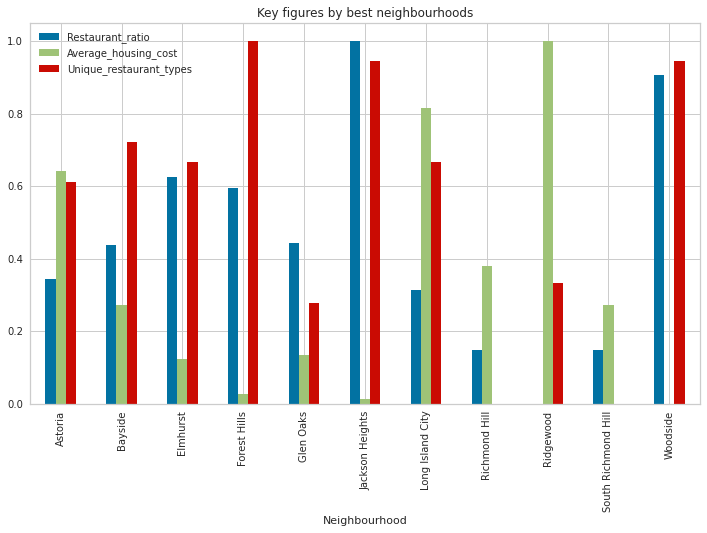

In [197]:
# Create a bar graph of our normalised data for our optimal cluster.
best_cluster_norm.plot.bar(title="Key figures by best neighbourhoods", figsize=(12,7))

Jackson Heights or Woodside are our best options. While Jackson Heights has a better restaurant/other business ratio than Woodside, Woodside has cheaper real estate prices. Both offer equally diverse culinary experiences. However... Let's take a closer look at the specific types of restaurants in these areas. This might give us our clear winners.

In [201]:
# Step 1: Filter the dataframe to only show the data for Jackson Heights
Jackson_heights_restaurants = Queens_Restaurants.loc[Queens_Restaurants["Neighbourhood"] == "Jackson Heights"]

# Step 2: Display a list of Restaurant Categories
Jackson_heights_restaurants["Venue Category"].unique()

array(['Italian Restaurant', 'Restaurant', 'Latin American Restaurant',
       'Peruvian Restaurant', 'Thai Restaurant', 'Empanada Restaurant',
       'Argentinian Restaurant', 'Paella Restaurant',
       'Cajun / Creole Restaurant', 'South American Restaurant',
       'Indian Restaurant', 'Food Truck', 'Cuban Restaurant',
       'Spanish Restaurant', 'Mexican Restaurant', 'Tibetan Restaurant',
       'Arepa Restaurant', 'Burger Joint', 'Asian Restaurant',
       'Colombian Restaurant', 'Vegetarian / Vegan Restaurant',
       'Mediterranean Restaurant', 'Dumpling Restaurant',
       'Vietnamese Restaurant', 'Greek Restaurant',
       'Salvadoran Restaurant'], dtype=object)

In [202]:
# Step 1: Filter the dataframe to only show the data for Woodside
Woodside_restaurants = Queens_Restaurants.loc[Queens_Restaurants["Neighbourhood"] == "Woodside"]

# Step 2: Display a list of Restaurant Categories
Woodside_restaurants["Venue Category"].unique()

array(['Chinese Restaurant', 'American Restaurant',
       'Fast Food Restaurant', 'Thai Restaurant', 'Mexican Restaurant',
       'Latin American Restaurant', 'Burger Joint',
       'Himalayan Restaurant', 'Sushi Restaurant', 'Food Truck',
       'Japanese Restaurant', 'Filipino Restaurant', 'Arepa Restaurant',
       'Korean Restaurant', 'Tibetan Restaurant', 'French Restaurant',
       'Indian Restaurant', 'Turkish Restaurant', 'Italian Restaurant',
       'Fried Chicken Joint', 'Vietnamese Restaurant',
       'Southern / Soul Food Restaurant', 'Health Food Store',
       'Vegetarian / Vegan Restaurant', 'Peruvian Restaurant',
       'Dumpling Restaurant'], dtype=object)

Both neighbourhoods offer quite a lot of different cuisines. Where Jackson Heights focuses more on South-American cuisines, Woodside has a more diverse offering of Asian cuisines. 

However, Woodside already has a French restaurant. As the French cuisine is quite similar to Belgian cuisine, Jackson Heights is our final winner.

Let's take this one step further and identify the best areas in this neighbourhood to start up a restaurant! We can do this by visualising the fetched restaurants on a Folium map and identify clusters of Restaurants.

In [215]:
# Step 1: Retrieve the latitude & longitude of Jackson Heights
latitude = Jackson_heights_restaurants["Neighbourhood Latitude"][1825]
longitude = Jackson_heights_restaurants["Neighbourhood Longitude"][1825]

# Step 2: Create the map
Jackson_Heights_map = folium.Map(location=[latitude, longitude], zoom_start=15)

# Step 3: Add the markers for the restaurants
for lat, lon, name, cat in zip(Jackson_heights_restaurants["Venue Latitude"], Jackson_heights_restaurants["Venue Longitude"], Jackson_heights_restaurants["Venue"], Jackson_heights_restaurants["Venue Category"]):
    label = folium.Popup(str(name) + " Category: " + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7).add_to(Jackson_Heights_map)
       
Jackson_Heights_map

We can clearly see 2 clusters of restaurants on the map that resemble vertical lines. One at the bottom of our map and one near the top.
The one at the top is in the area of restaurant "Dela Mora" & the bottom one is near restaurant "Lali Guras Restaurant". 

The geopy library also offers a reverse search that'll retrieve the address for a set of coordinates. Luckily, we actually have the coordinates for all of our venues! Let's plug those into the reverse search and find our optimal areas.

In [251]:
# Get the coordinates for location 1
Loc1 = Jackson_heights_restaurants.loc[Jackson_heights_restaurants["Venue"] == "Dela Mora"].reset_index()
Loc1_lat = Loc1["Venue Latitude"]
Loc1_lng = Loc1["Venue Longitude"]

# Get the coordinates for location 2
Loc2 = Jackson_heights_restaurants.loc[Jackson_heights_restaurants["Venue"] == "Lali Guras Restaurant"].reset_index()
Loc2_lat = Loc2["Venue Latitude"]
Loc2_lng = Loc2["Venue Longitude"]

In [229]:
# Enter the first set of coordinates into geolocater.reverse
Location_1 = geolocator.reverse("{}, {}".format(Loc1_lat[0],Loc1_lng[0]))
Location_1

Location(84-19, Northern Boulevard, East Elmhurst, Jackson Heights, Queens, Queens County, New York, 11370, United States, (40.756071000000006, -73.8828288, 0.0))

In [252]:
# Enter the second set of coordinates into geolocater.reverse
Location_2 = geolocator.reverse("{}, {}".format(Loc2_lat[0],Loc2_lng[0]))
Location_2

Location(76-02, 37th Road, Queens, Queens County, New York, 11372, United States, (40.7473816, -73.8894869, 0.0))

There we go! The best areas to set up a Belgian restaurant in New York City would be in Jackson Heights. More specifically in the areas of 84-19, Northern Boulevard or 76-02, 37th Road.